In [184]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [185]:
img = cv2.imread('clocks/clock2.png')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [186]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
kp1, des1 = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp1,img,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

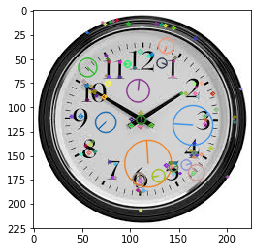

In [187]:
plt.imshow(img, cmap='gray')

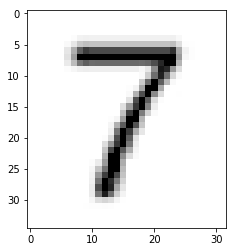

In [188]:
hay_img = 'clocks/num7.png'
hay_img = cv2.cvtColor(cv2.imread(hay_img), cv2.COLOR_BGR2GRAY)
hay_edges = cv2.Canny(hay_img,100,200)

plt.imshow(hay_img, cmap='gray')

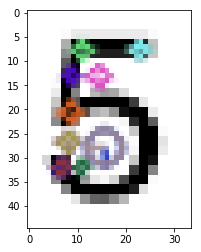

In [189]:
sift2 = cv2.xfeatures2d.SIFT_create()
kp2, des2 = sift2.detectAndCompute(num2,None)
img2=cv2.drawKeypoints(num2,kp2,num2,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img2, cmap='gray')

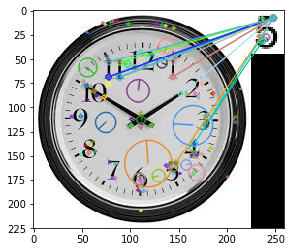

(<matplotlib.image.AxesImage at 0x61d499b50>, None)

In [190]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# Match descriptors.
matches = bf.match(des1,des2)
#Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# # Apply ratio test
# good = []
# for m,n in matches:
#     if m.distance < 0.75*n.distance:
#         good.append([m])
# Draw first 10 matches.
img3 = cv2.drawMatches(img,kp1,img2,kp2,matches[:15], None,flags=2)
plt.imshow(img3),plt.show()

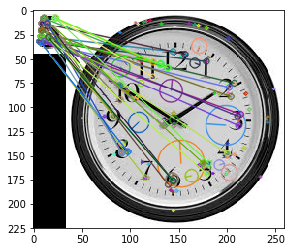

(<matplotlib.image.AxesImage at 0x61d87fa50>, None)

In [191]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des2,des1, k=3)
# Apply ratio test
good = []
for pts in matches:
#     if m.distance < 0.75*n.distance:
    good.append([x for x in pts if x.distance < pts[0].distance * 1.3])
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img2,kp2,img,kp1,good,None,flags=2)
plt.imshow(img3),plt.show()

In [192]:
good

[[<DMatch 0x110abbb90>, <DMatch 0x1100f5af0>, <DMatch 0x1100f5610>],
 [<DMatch 0x1100f5dd0>, <DMatch 0x1101d01b0>, <DMatch 0x1101d0d90>],
 [<DMatch 0x1101d01d0>, <DMatch 0x1101d0cf0>, <DMatch 0x1101d0d10>],
 [<DMatch 0x1101d0d30>, <DMatch 0x1101d0db0>, <DMatch 0x1101d0d50>],
 [<DMatch 0x1101d0f30>, <DMatch 0x11230e030>, <DMatch 0x11230e050>],
 [<DMatch 0x11230e070>, <DMatch 0x11230e090>, <DMatch 0x11230e0b0>],
 [<DMatch 0x11230e0d0>],
 [<DMatch 0x11230e130>, <DMatch 0x11230e150>, <DMatch 0x11230e170>],
 [<DMatch 0x11230e190>, <DMatch 0x11230e1b0>, <DMatch 0x11230e1d0>],
 [<DMatch 0x11230e1f0>, <DMatch 0x11230e210>, <DMatch 0x11230e230>],
 [<DMatch 0x11230e250>, <DMatch 0x11230e270>, <DMatch 0x11230e290>],
 [<DMatch 0x11230e2b0>, <DMatch 0x11230e2d0>, <DMatch 0x11230e2f0>],
 [<DMatch 0x11230e310>]]

In [193]:
from collections import defaultdict
def extract_matches(match_list_matrix, kp_1, kp_2):
    result = defaultdict(list)
    if len(match_list_matrix):
        if isinstance(match_list_matrix[0], list):
            for dmatch_list in match_list_matrix:
                for dmatch in dmatch_list:
                    #print(dmatch.trainIdx)
                    result[kp_2[dmatch.trainIdx]].append(dmatch)
        else:
            for dmatch in match_list_matrix:
                result[kp_2[dmatch.trainIdx]].append(dmatch)
    return result

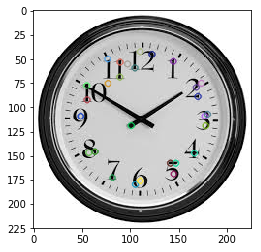

(<matplotlib.image.AxesImage at 0x61ce32ed0>, None)

In [194]:
result = extract_matches(good, kp2, kp1)
img4=cv2.drawKeypoints(gray,result.keys(), None)
plt.imshow(img4),plt.show()

In [195]:
good_matched_kp = sorted(result.keys(), key=lambda x: min([dmatch.distance for dmatch in result[x]]))[:20]

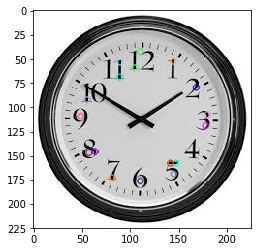

(<matplotlib.image.AxesImage at 0x61d053490>, None)

In [196]:
img5=cv2.drawKeypoints(gray,good_matched_kp, None)
plt.imshow(img5),plt.show()

In [197]:
len(good_matched_kp)

20

In [198]:
import pickle
contours = pickle.load(open('contours.pk'))

In [199]:
from collections import defaultdict
bb_map = defaultdict(int)
for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    bb_map[(x, y, w, h)] = 0

In [200]:
for good_kp in good_matched_kp:
    x_, y_ = good_kp.pt
    for x, y,  w, h in bb_map:
        if x_ >= x and x_ <= x + w and y_ >= y and y_ <= y + h:
            #print('aha')
            bb_map[(x, y, w, h)] += 1

In [201]:
candidate_bb = []
for bb, score in sorted(bb_map.items(), key=lambda x: -x[1]):
    x, y, w, h = bb
    if max(w, h) > max(img.shape)/3 or not score:
        continue
    candidate_bb.append(bb)
#     if len(candidate_bb) > 10:
#         break

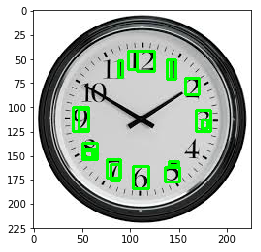

In [202]:
img = cv2.imread('clocks/clock2.png')
for x, y, w, h in candidate_bb:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img)
plt.show()

In [203]:
# return positive number if there's overlap, o/w return negative number of their distance
def overlap_bw_segment(line1, line2):
    a1, a2 = line1
    b1, b2 = line2
    if a2 <= b1:
        return a2 - b1
    if a1 >= b2:
        return b2 - a1
    return min(a2, b2) - max(a1, b1)

def decide_merge(bb1, bb2, overlap_ratio):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    x_overlap = overlap_bw_segment((x1, x1+w1), (x2, x2+w2))
    print(x_overlap)
    y_overlap = overlap_bw_segment((y1, y1+h1), (y2, y2+h2))
    print(y_overlap)
    x_ratio = x_overlap*1.0 / min(w1, w2)
    y_ratio = y_overlap*1.0/ min(h1, h2)
    print(x_ratio)
    print(y_ratio)
    return min(x_ratio, y_ratio) >= -(1 - overlap_ratio) and max(x_ratio, y_ratio) >= overlap_ratio

def merge_two_bb(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return new_x, new_y, new_w, new_h
    
def merge_bb(bb_list, overlap_ratio=0.6):
    new_bb_list = []
    while True:
        merged_idx = set()
        new_bb_list = []
        for i in range(len(bb_list)):
            if i in merged_idx: continue
            for j in range(i+1, len(bb_list)):
                if j in merged_idx: continue
                if decide_merge(bb_list[i], bb_list[j], overlap_ratio):
                    merged_idx.add(i)
                    merged_idx.add(j)
                    new_bb_list.append(merge_two_bb(bb_list[i], bb_list[j]))
                    break
        if not new_bb_list: break
        bb_list = [bb_list[i] for i in range(len(bb_list)) if i not in merged_idx] + new_bb_list
    return bb_list

In [204]:
merged_candidate_bb = merge_bb(candidate_bb)

11
9
1.0
1.0
10
21
1.0
1.0
-11
-92
-2.75
-5.41176470588
-48
-87
-12.0
-17.4
-76
-34
-19.0
-2.0
-48
-87
-12.0
-21.75
-15
11
-3.75
0.647058823529
-50
17
-12.5
1.0
1
-90
0.25
-5.29411764706
2
-85
0.5
-5.0
-46
17
-11.5
1.0
-6
9
-1.5
0.529411764706
-27
-76
-6.75
-8.44444444444
-44
-93
-11.0
-6.2
-65
-1
-16.25
-0.0588235294118
-82
-44
-20.5
-4.88888888889
-21
0
-2.1
0.0
-49
-36
-3.26666666667
-1.63636363636
-21
-1
-2.1
-0.25
12
-98
0.75
-4.66666666667
-23
-90
-4.6
-4.5
-14
15
-1.55555555556
0.882352941176
-13
12
-0.928571428571
0.631578947368
-19
-90
-2.11111111111
-4.5
4
-100
0.444444444444
-5.26315789474
-42
-7
-4.2
-0.777777777778
-17
15
-1.13333333333
1.0
-38
-74
-2.71428571429
-4.35294117647
-55
-39
-9.16666666667
-4.33333333333
-18
-31
-1.8
-6.2
10
4
1.0
1.0
-43
-40
-2.86666666667
-1.90476190476
-21
-32
-4.2
-1.6
-79
-34
-8.77777777778
-2.0
-78
-29
-5.57142857143
-1.52631578947
-21
-32
-2.33333333333
-1.6
-61
-42
-6.77777777778
-2.21052631579
-107
-20
-10.7
-2.22222222222
-17
-37
-1.13

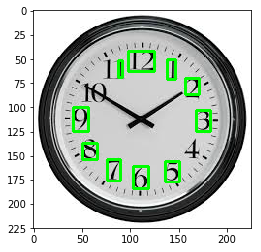

In [212]:
img = cv2.imread('clocks/clock2.png')
for x, y, w, h in merged_candidate_bb:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
plt.imshow(img)
plt.show()

In [213]:
merged_candidate_bb

[(88, 52, 4, 17),
 (103, 161, 16, 23),
 (157, 70, 14, 17),
 (41, 100, 16, 25),
 (168, 103, 15, 22),
 (98, 42, 27, 21),
 (138, 51, 9, 20),
 (76, 154, 14, 22),
 (51, 137, 15, 17),
 (136, 156, 15, 21)]

In [214]:
def get_contours(edges, bb=None):
    if bb is not None:
        x, y, w, h = bb
        edges = edges[y:y+h, x:x+w]
#     return edges
    return cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [215]:
img = cv2.imread('clocks/clock2.png', 0)
edges = cv2.Canny(img,100,200) #TODO tune here
i1, hay_contours, _ = get_contours(hay_edges)
# a = cv2.HuMoments(cv2.moments(hay_img)).flatten()
distance_extractor = cv2.createShapeContextDistanceExtractor()
for bb in merged_candidate_bb:
    i2, partial_edges, _ = get_contours(edges, bb)
#     b = cv2.HuMoments(cv2.moments(partial_edges)).flatten()
#     dist = cosine(a, b)
    dist = distance_extractor.computeDistance(np.concatenate(partial_edges), np.concatenate(hay_contours))
    
    print(dist)
#     break

error: /opt/concourse/worker/volumes/live/3b96f7c7-93a4-48c6-665d-2f7ff1dac914/volume/opencv_1512680443756/work/modules/core/src/matmul.cpp:1218: error: (-215) type == (((6) & ((1 << 3) - 1)) + (((2)-1) << 3)) in function gemmImpl


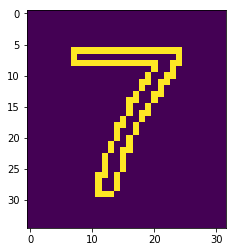

In [210]:
plt.imshow(i1)

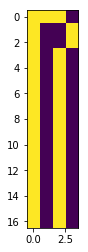

In [211]:
plt.imshow(i2)

In [216]:
partial_edges

[array([[[ 0,  0]],
 
        [[ 0, 16]],
 
        [[ 0,  1]],
 
        [[ 1,  0]],
 
        [[ 2,  0]],
 
        [[ 3,  1]],
 
        [[ 3,  2]],
 
        [[ 2,  3]],
 
        [[ 2, 16]],
 
        [[ 2,  3]],
 
        [[ 3,  2]],
 
        [[ 3,  1]],
 
        [[ 2,  0]]], dtype=int32)]

In [217]:
hay_contours

[array([[[ 7,  6]],
 
        [[ 7,  8]],
 
        [[19,  8]],
 
        [[20,  9]],
 
        [[18, 11]],
 
        [[18, 12]],
 
        [[16, 14]],
 
        [[16, 16]],
 
        [[14, 18]],
 
        [[14, 20]],
 
        [[13, 21]],
 
        [[13, 22]],
 
        [[12, 23]],
 
        [[12, 25]],
 
        [[11, 26]],
 
        [[11, 29]],
 
        [[13, 29]],
 
        [[14, 28]],
 
        [[14, 26]],
 
        [[15, 25]],
 
        [[15, 23]],
 
        [[16, 22]],
 
        [[16, 20]],
 
        [[17, 19]],
 
        [[17, 18]],
 
        [[19, 16]],
 
        [[19, 15]],
 
        [[21, 13]],
 
        [[21, 12]],
 
        [[23, 10]],
 
        [[23,  9]],
 
        [[24,  8]],
 
        [[24,  6]]], dtype=int32), array([[[ 7,  7]],
 
        [[ 8,  6]],
 
        [[23,  6]],
 
        [[24,  7]],
 
        [[23,  8]],
 
        [[23,  9]],
 
        [[21, 11]],
 
        [[21, 12]],
 
        [[20, 13]],
 
        [[20, 14]],
 
        [[18, 16]],
 
        [[18, 17]],


In [218]:
np.concatenate(partial_edges).shape

(13, 1, 2)

In [219]:
np.concatenate(hay_contours).shape

(74, 1, 2)